# Descarga datos

In [ ]:
import requests
from pandas.io.json import json_normalize
import pandas as pd

url="https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=1000000000"
Datos=pd.read_json(url,convert_dates=['fecha_de_notificaci_n','fecha_de_muerte','fis','fecha_diagnostico','fecha_recuperado','fecha_reporte_web'])

In [ ]:
Datos.rename(columns={'id_de_caso':'id_caso','fecha_de_notificaci_n':'fecha_notificacion','c_digo_divipola':'codigo_municipio','ciudad_de_ubicaci_n':'ciudad',
                      'atenci_n':'atencion','tipo':'tipo_contagio','estado':'estado','pa_s_de_procedencia':'pais_procedencia','fis':'fecha_sintomas',
                      'tipo_recuperaci_n':'tipo_recuperacion','fecha_de_muerte':'fecha_muerte'},inplace=True)

In [ ]:
Datos

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09,2020-03-19,2020-03-09,PCR,76,724.0,Otro,NaN,NaT
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650057,650098,2020-08-23,5147,Carepa,Antioquia,Casa,39,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650058,650099,2020-08-23,5266,Envigado,Antioquia,Casa,40,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650059,650100,2020-08-23,5360,Itagüí,Antioquia,Casa,58,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT
650060,650101,2020-08-23,5360,Itagüí,Antioquia,Casa,78,M,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,5,NaN,NaN,NaN,NaT


# Análisis datos y dataset final para modelar

In [ ]:
# Cuenta vacíos
Datos.isna().sum()

id_caso                     0
fecha_notificacion          0
codigo_municipio            0
ciudad                      0
departamento                0
atencion                    0
edad                        0
sexo                        0
tipo_contagio               0
estado                      0
pais_procedencia       649097
fecha_sintomas              0
fecha_diagnostico        3976
fecha_recuperado       151836
fecha_reporte_web           0
tipo_recuperacion      151841
codigo_departamento         0
codigo_pais            649101
pertenencia_etnica     366607
nombre_grupo_etnico    638737
fecha_muerte           627849
dtype: int64

In [ ]:
# 5 principales ciudades: Bogotá, Medellín, Cali, Barranquilla y Cartagena de Indias, coincide con las de más casos
Datos['ciudad'].value_counts().head(10)

Bogotá D.C.            221738
Medellín                49932
Cali                    38466
Barranquilla            36520
Cartagena de Indias     20758
Soledad                 13922
Montería                12613
Valledupar               9127
Bucaramanga              9047
Soacha                   8941
Name: ciudad, dtype: int64

In [ ]:
# filtrando ciudades
Datos1=Datos[Datos['ciudad'].isin(['Cartagena de Indias'])]
Datos1.reset_index(inplace=True,drop=True)
Datos1

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,7,2020-03-08,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,85,F,Importado,Leve,ESTADOS UNIDOS,2020-03-02T00:00:00.000,2020-03-11,2020-03-17,2020-03-11,PCR,13,840.0,Otro,NaN,NaT
1,26,2020-03-15,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,30,F,Relacionado,Asintomático,NaN,Asintomático,2020-03-15,2020-03-25,2020-03-15,PCR,13,NaN,Otro,NaN,NaT
2,27,2020-03-15,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,30,F,Relacionado,Asintomático,NaN,Asintomático,2020-03-15,2020-03-25,2020-03-15,PCR,13,NaN,Otro,NaN,NaT
3,58,2020-03-13,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,27,M,Relacionado,Leve,NaN,2020-03-13T00:00:00.000,2020-03-16,2020-03-27,2020-03-16,PCR,13,NaN,NaN,NaN,NaT
4,73,2020-03-16,13001,Cartagena de Indias,Cartagena D.T. y C.,Recuperado,54,F,Relacionado,Leve,NaN,2020-03-14T00:00:00.000,2020-03-17,2020-03-28,2020-03-17,PCR,13,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,649648,2020-08-23,13001,Cartagena de Indias,Cartagena D.T. y C.,Casa,62,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,13,NaN,NaN,NaN,NaT
20754,649649,2020-08-23,13001,Cartagena de Indias,Cartagena D.T. y C.,Casa,49,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,13,NaN,NaN,NaN,NaT
20755,649650,2020-08-23,13001,Cartagena de Indias,Cartagena D.T. y C.,Casa,37,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,13,NaN,NaN,NaN,NaT
20756,649776,2020-08-23,13001,Cartagena de Indias,Cartagena D.T. y C.,Casa,39,M,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-03,NaT,2020-09-04,NaN,13,NaN,NaN,NaN,NaT


# **Metodologías propuestas y desarrollo de los modelos**

## Metodología 1: Nuevos ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

In [ ]:
tabla_nuevos

,fecha_reporte_web,casos_nuevos_reportados,casos_confirmados
0,2020-03-11,1,1
1,2020-03-15,2,3
2,2020-03-16,2,5
3,2020-03-17,1,6
4,2020-03-18,3,9
...,...,...,...
159,2020-08-28,59,20147
160,2020-08-29,124,20271
161,2020-08-30,90,20361
162,2020-08-31,82,20443


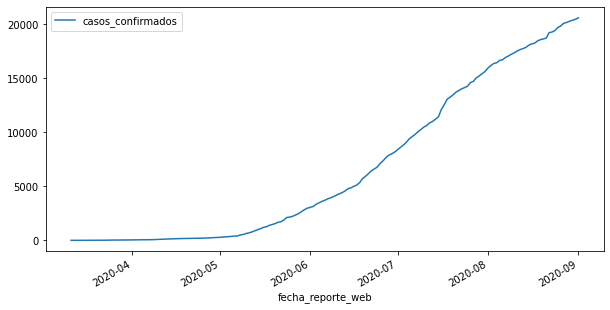

In [ ]:
# los casos confirmados no pueden ser con modelo basado en la tendencia, se tiene que predecir con el resultado de la suma de los casos nuevos reportados
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_confirmados',figsize=(10, 5)).figure.savefig('1.png')

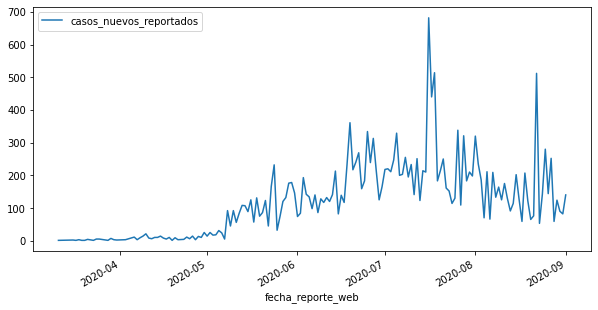

In [ ]:
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_nuevos_reportados',figsize=(10, 5)).figure.savefig('2.png')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mean1=52.475610, mean2=198.536585
variance1=3442.883551, variance2=11432.492564


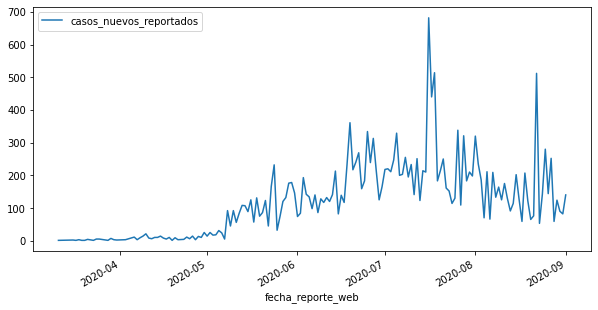

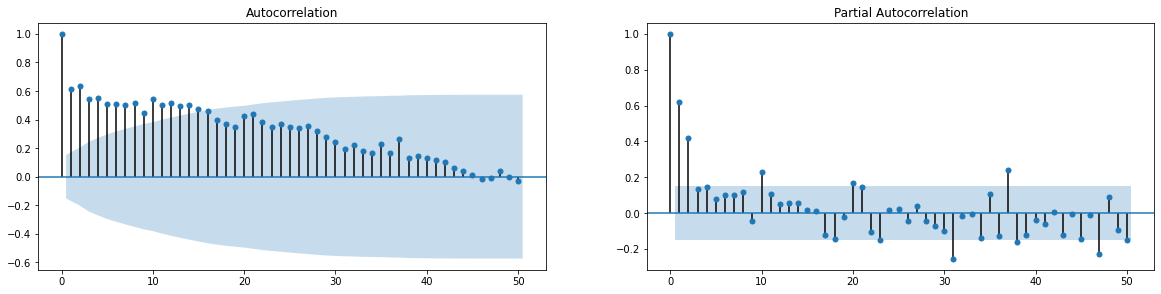

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M1Nuevos=M1Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M1Nuevos.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Nuevos.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Nuevos, lags=50, ax=ax2)

X=M1Nuevos.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=2.961714, mean2=5.162431
variance1=2.725272, variance2=0.261184


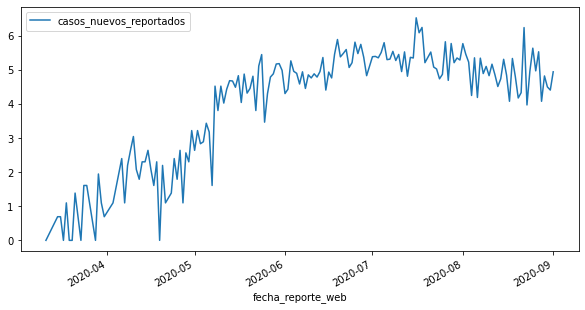

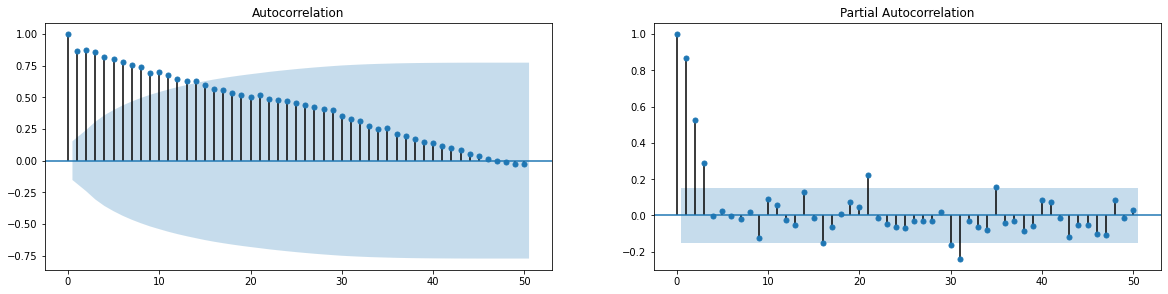

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1NuevosLog=np.log(M1Nuevos)
plt.rcParams["figure.figsize"] = (10,5)
M1NuevosLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLog, lags=50, ax=ax2)

X=M1NuevosLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

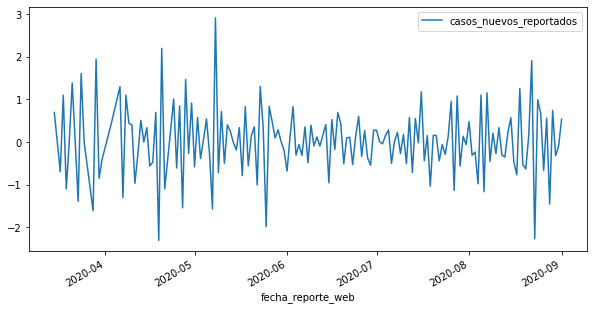

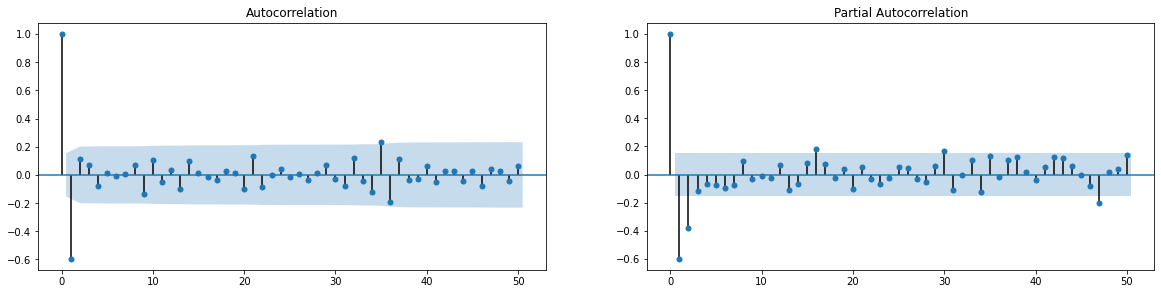

In [ ]:
# Primera diferencia para volver estacional
M1NuevosLogDif=M1NuevosLog.diff()
M1NuevosLogDif=M1NuevosLogDif[1:]
M1NuevosLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(164, 1)
(131, 1)
(19, 1)
(14, 1)


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 4.1MB/s 
     |████████████████████████████████| 2.1MB 11.5MB/s 
     |████████████████████████████████| 9.5MB 44.8MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  131
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -116.195
Date:                Wed, 02 Sep 2020   AIC                            240.391
Time:                        18:48:08   BIC                            251.861
Sample:                             0   HQIC                           245.051
                                - 131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0494      0.023      2.176      0.030       0.005       0.094
ar.L1         -0.2737      0.104     -2.633      0.008      -0.477      -0.070
ma.L1         -0.5776      0.093     -6.222      0.000      -0.760      -0.396
sigma2         0.3478      0.037      9.291      0.000       0.274       0.421
===================================================================================
Ljung-Box (Q):                       32.53   Jarque-Bera (JB):                 5.79
Prob(Q):                              0.79   Prob(JB):                         0.06
Heteroskedasticity (H):               0.41   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


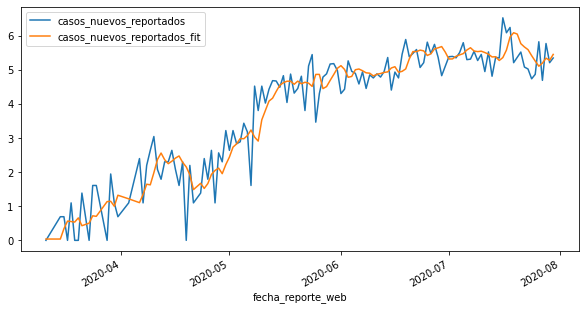

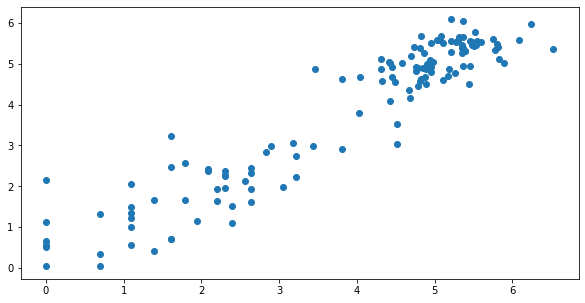

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


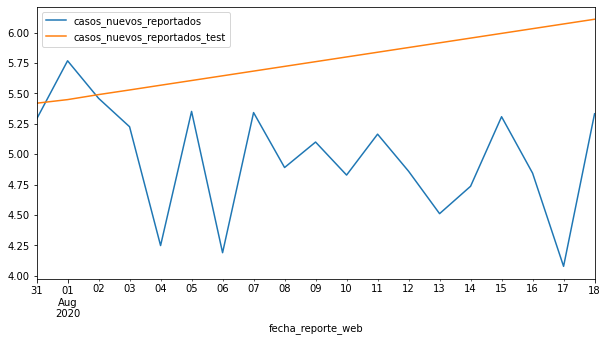

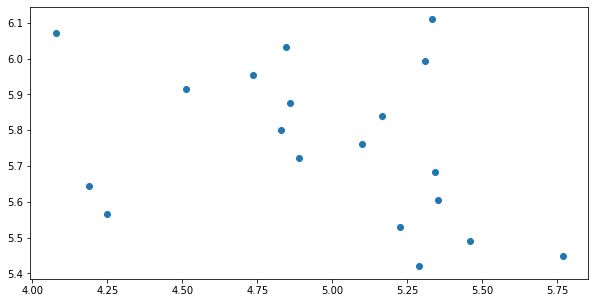

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5)).figure.savefig('3.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.savefig('4.png')
plt.show()


M1NuevosLogTest['casos_nuevos_reportados_test']=arima.predict(n_periods=(len(M1NuevosLogTest))) 
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5)).figure.savefig('5.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.savefig('6.png')
plt.show()

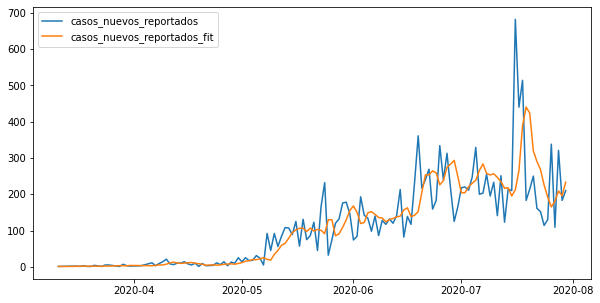

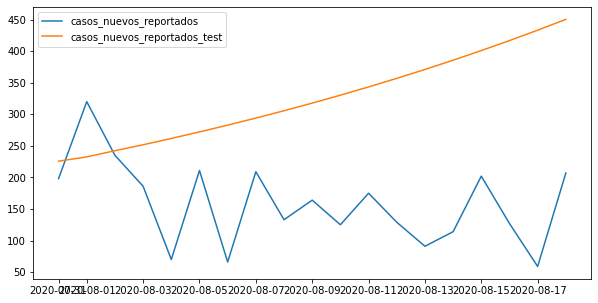

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fit'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fit'])
plt.savefig('7.png')
plt.show()

FM1NuevosTest=np.exp(M1NuevosLogTest)
plt.plot(FM1NuevosTest['casos_nuevos_reportados'])
plt.plot(FM1NuevosTest['casos_nuevos_reportados_test'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_test'])
plt.savefig('8.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Nuevos['casos_nuevos_reportados'],FM1Nuevos['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1NuevosTest['casos_nuevos_reportados'],FM1NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 5719.862719
MSE in test: 39906.964062


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(162, 1)
(129, 1)
(20, 1)
(13, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


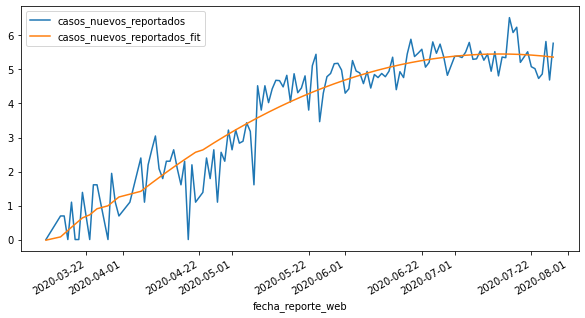

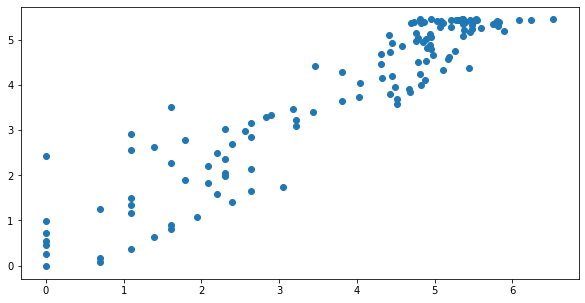

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


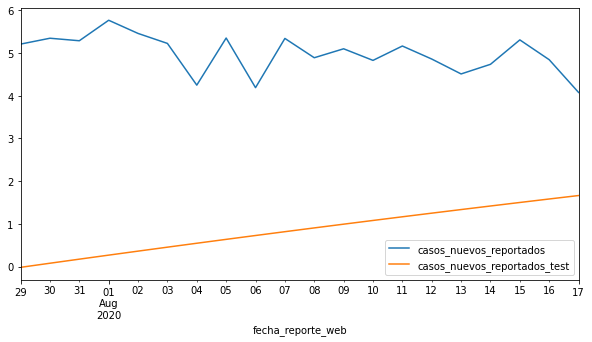

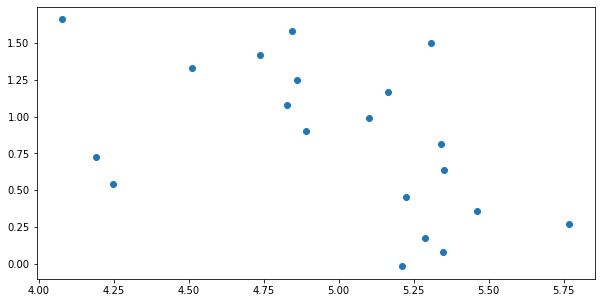

Mean squared error: 0.37
Variance score: 0.88


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1NuevosLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1NuevosLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1NuevosLogTrain['casos_nuevos_reportados'].values.reshape(-1,1))
M1NuevosLogTrain['casos_nuevos_reportados_fit']=model.predict(x_trainpoly)

plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.show()

M1NuevosLogTest['casos_nuevos_reportados_test']=model.predict(x_testpoly)
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])))

print('Variance score: %.2f' % r2_score(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit']))

#4,3,2
#Mean squared error: 0.15, 0.19, 0.24
#Variance score: 0.96, 0.95, 0.94

# LinnearRegression() 0.24, 0.94

In [ ]:
M1NuevosLogTrain['Errores']=M1NuevosLogTrain['casos_nuevos_reportados']-M1NuevosLogTrain['casos_nuevos_reportados_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/loc

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -109.296
Date:                Tue, 01 Sep 2020   AIC                            226.591
Time:                        03:10:58   BIC                            238.030
Sample:                             0   HQIC                           231.239
                                - 129                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7257      0.150      4.853      0.000       0.433       1.019
ma.L1         -0.6722      0.160     -4.214      0.000      -0.985      -0.360
ma.L2          0.2347      0.094      2.490      0.013       0.050       0.419
sigma2         0.3180      0.030     10.452      0.000       0.258       0.378
===================================================================================
Ljung-Box (Q):                       35.21   Jarque-Bera (JB):                22.82
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


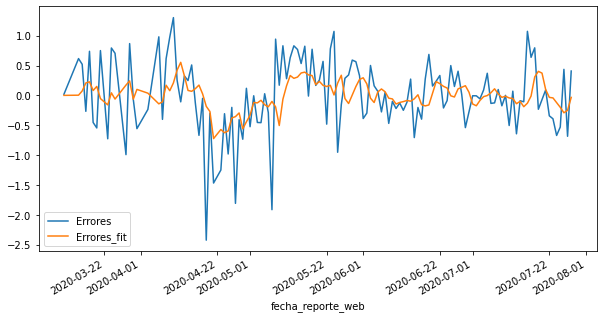

In [ ]:
M1NuevosLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


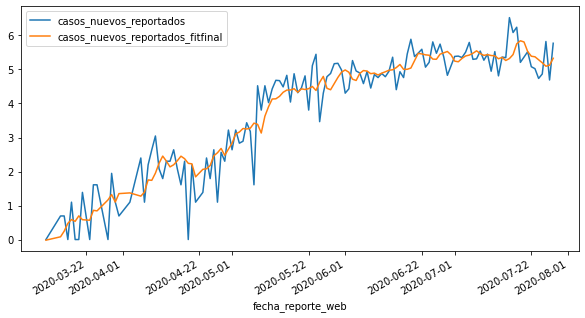

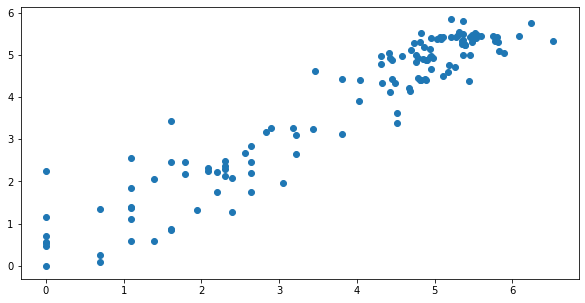

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fitfinal']=M1NuevosLogTrain['casos_nuevos_reportados_fit']+M1NuevosLogTrain['Errores_fit']
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


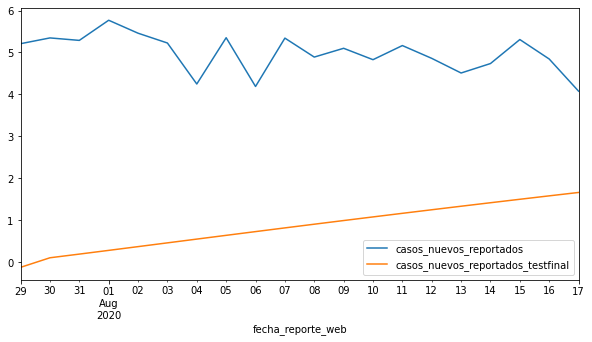

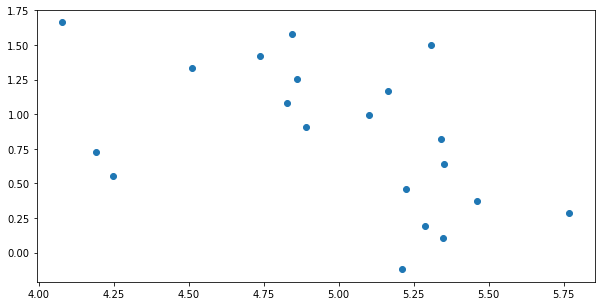

In [ ]:
M1NuevosLogTest['Errores_test']=arima.predict(n_periods=(len(M1NuevosLogTest)))
M1NuevosLogTest['casos_nuevos_reportados_testfinal']=M1NuevosLogTest['casos_nuevos_reportados_test']+M1NuevosLogTest['Errores_test']

plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_testfinal'])
plt.show() 

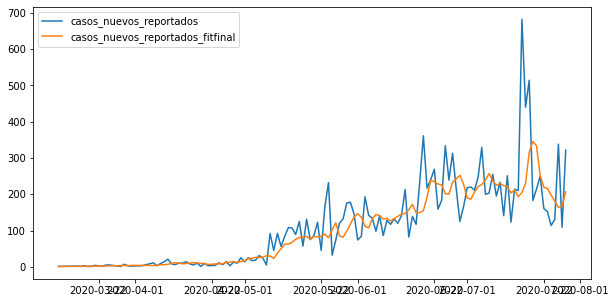

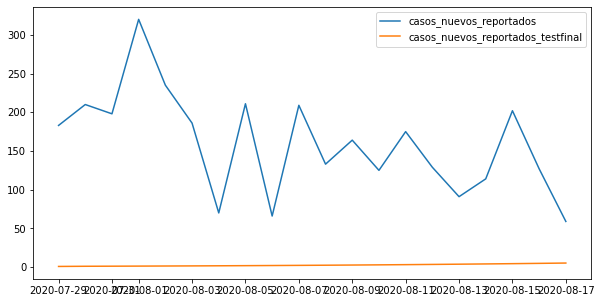

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fitfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fitfinal'])
plt.show()

FM1Nuevos=np.exp(M1NuevosLogTest)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_testfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Muerte ARIMA Y POLINOMIAL CON ERORRES ARIMA



In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

In [ ]:
tabla_muerte

,fecha_muerte,casos_muerte
0,2020-03-16,1
1,2020-03-27,1
2,2020-03-30,2
3,2020-03-31,1
4,2020-04-06,1
...,...,...
131,2020-08-25,1
132,2020-08-26,1
133,2020-08-28,1
134,2020-08-30,1


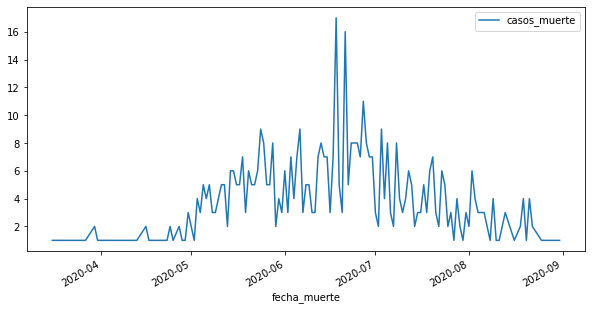

In [ ]:
tabla_muerte.plot(x='fecha_muerte',y='casos_muerte',figsize=(10, 5))

mean1=3.764706, mean2=4.294118
variance1=5.591696, variance2=10.325260


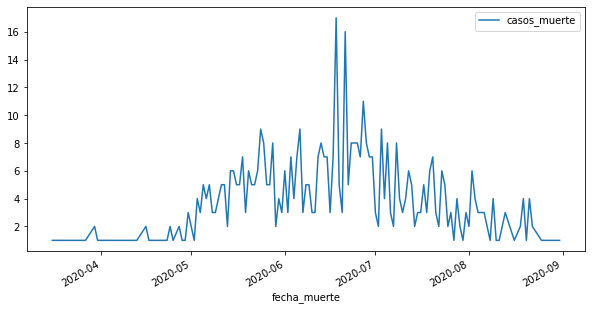

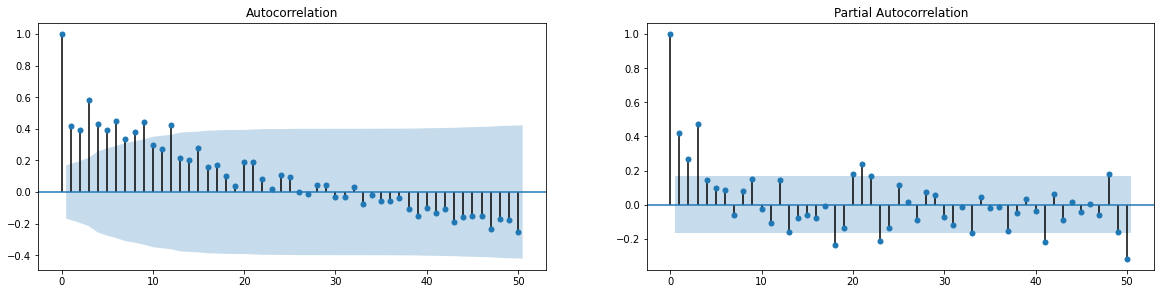

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M1Muerte.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Muerte.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Muerte, lags=50, ax=ax2)

X=M1Muerte.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=1.078675, mean2=1.197488
variance1=0.564760, variance2=0.547863


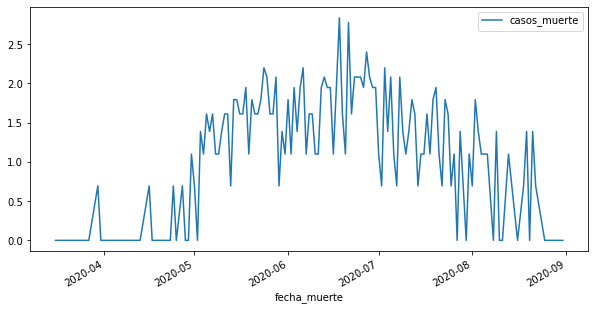

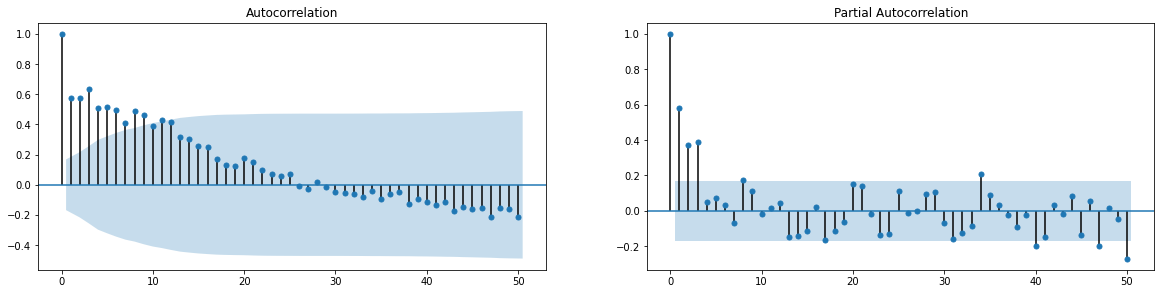

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1MuerteLog=np.log(M1Muerte)
plt.rcParams["figure.figsize"] = (10,5)
M1MuerteLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLog, lags=50, ax=ax2)

X=M1MuerteLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

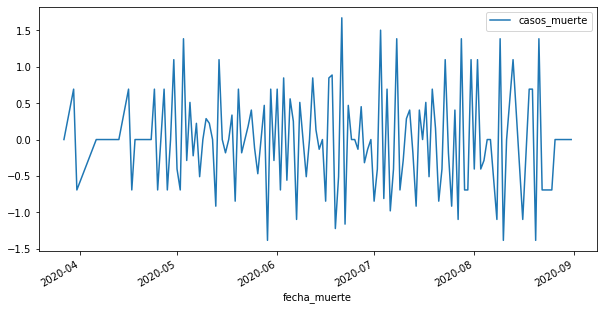

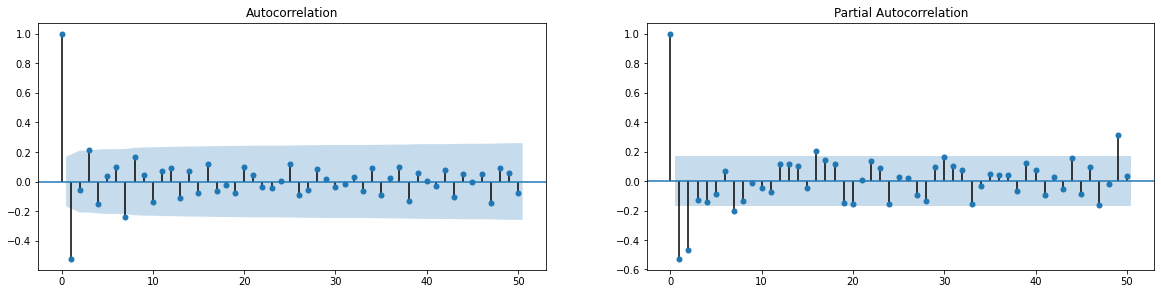

In [ ]:
# Primera diferencia para volver estacional
M1MuerteLogDif=M1MuerteLog.diff()
M1MuerteLogDif=M1MuerteLogDif[1:]
M1MuerteLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(136, 1)
(108, 1)
(17, 1)
(11, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 -71.453
Date:                Wed, 02 Sep 2020   AIC                            150.907
Time:                        18:49:46   BIC                            161.598
Sample:                             0   HQIC                           155.241
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8448      0.095     -8.860      0.000      -1.032      -0.658
ma.L2         -0.0347      0.130     -0.266      0.790      -0.290       0.221
ma.L3          0.1629      0.087      1.867      0.062      -0.008       0.334
sigma2         0.2205      0.034      6.574      0.000       0.155       0.286
===================================================================================
Ljung-Box (Q):                       31.16   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.84   Prob(JB):                         0.60
Heteroskedasticity (H):               1.42   Skew:                            -0.21
Prob(H) (two-sided):                  0.30   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


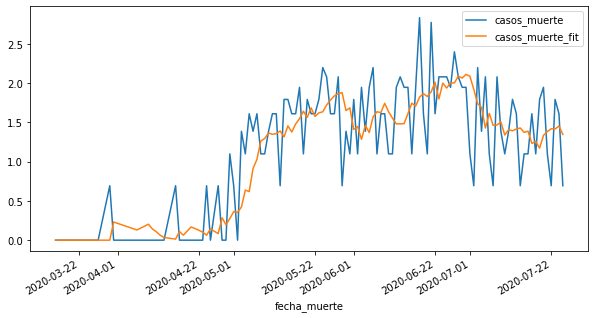

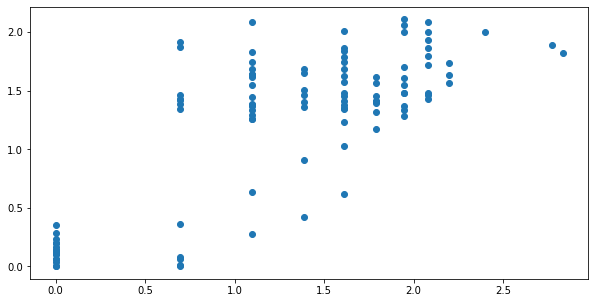

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


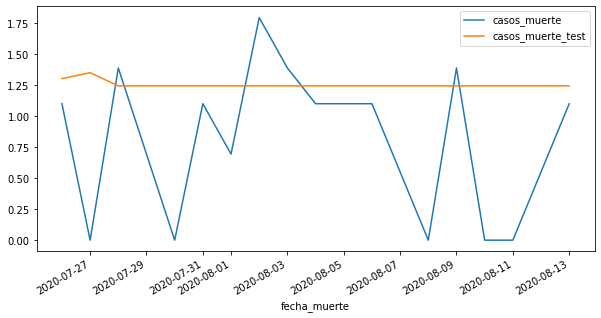

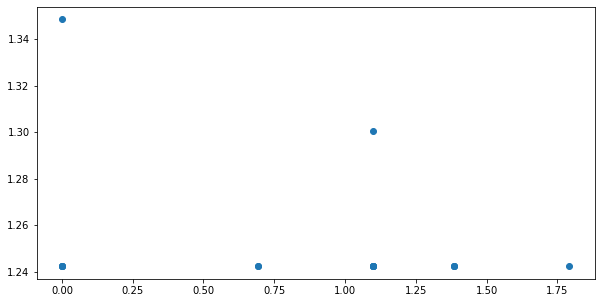

In [ ]:
M1MuerteLogTrain['casos_muerte_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()



M1MuerteLogTest['casos_muerte_test']=arima.predict(n_periods=(len(M1MuerteLogTest))) 
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

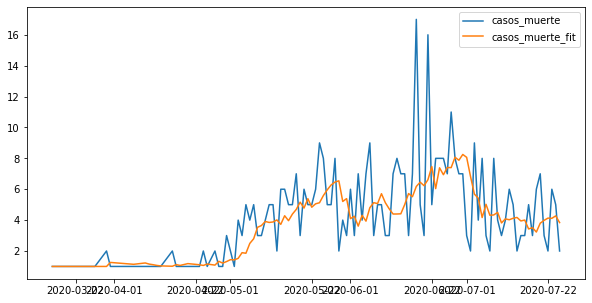

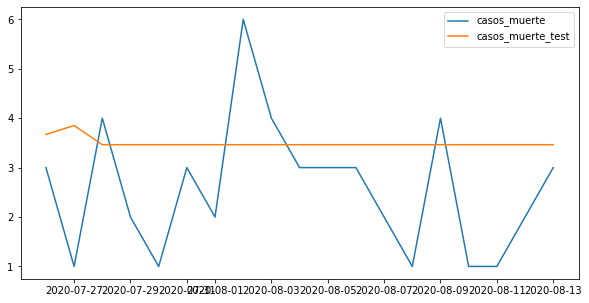

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fit'])
plt.legend(['casos_muerte','casos_muerte_fit'])
plt.show()

FM1MuerteTest=np.exp(M1MuerteLogTest)
plt.plot(FM1MuerteTest['casos_muerte'])
plt.plot(FM1MuerteTest['casos_muerte_test'])
plt.legend(['casos_muerte','casos_muerte_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Muerte['casos_muerte'],FM1Muerte['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1MuerteTest['casos_muerte'],FM1MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 5.566943
MSE in test: 2.676764


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(135, 1)
(108, 1)
(16, 1)
(11, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


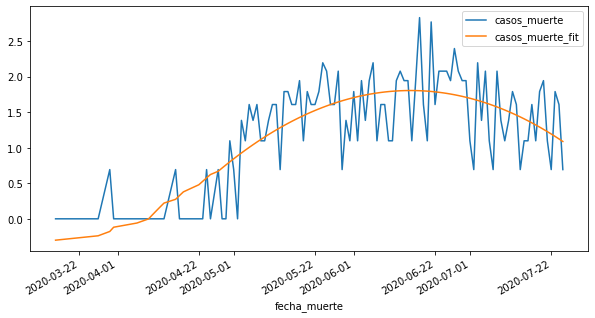

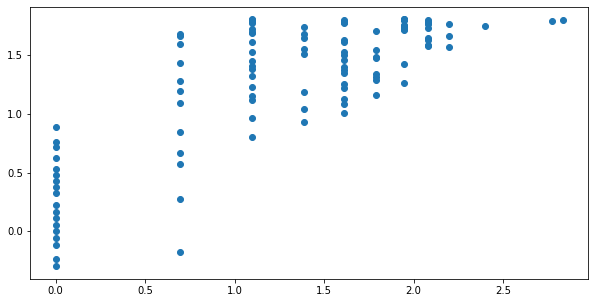

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


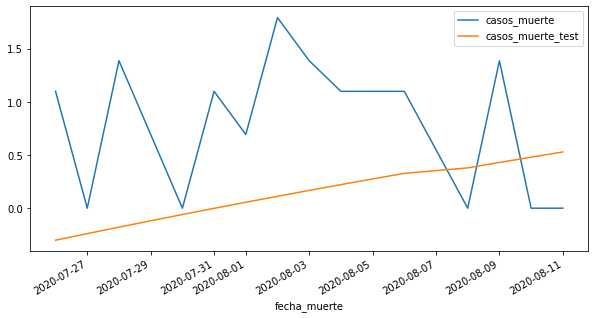

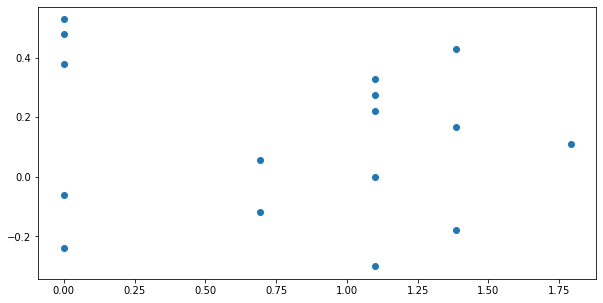

Mean squared error: 0.21
Variance score: 0.61


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1MuerteLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1MuerteLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=3)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1MuerteLogTrain['casos_muerte'].values.reshape(-1,1))
M1MuerteLogTrain['casos_muerte_fit']=model.predict(x_trainpoly)

plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()

M1MuerteLogTest['casos_muerte_test']=model.predict(x_testpoly)
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])))

print('Variance score: %.2f' % r2_score(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit']))

#3
#Mean squared error: 0.11
#Variance score: 0.94

# LinnearRegression()

In [ ]:
M1MuerteLogTrain['Errores']=M1MuerteLogTrain['casos_muerte']-M1MuerteLogTrain['casos_muerte_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                        SARIMAX   Log Likelihood                 -67.677
Date:                Tue, 01 Sep 2020   AIC                            137.353
Time:                        03:13:00   BIC                            140.036
Sample:                             0   HQIC                           138.441
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2050      0.034      6.052      0.000       0.139       0.271
===================================================================================
Ljung-Box (Q):                       58.12   Jarque-Bera (JB):                 2.81
Prob(Q):                              0.03   Prob(JB):                         0.25
Heteroskedasticity (H):               1.35   Skew:                            -0.23
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


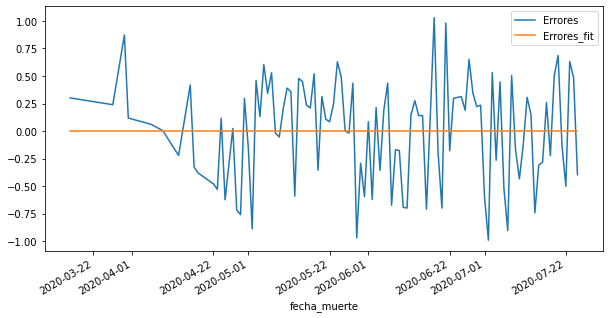

In [ ]:
M1MuerteLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


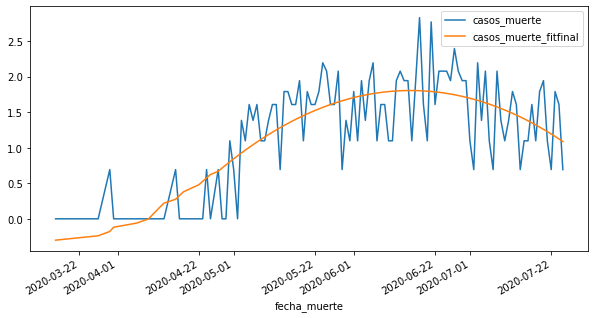

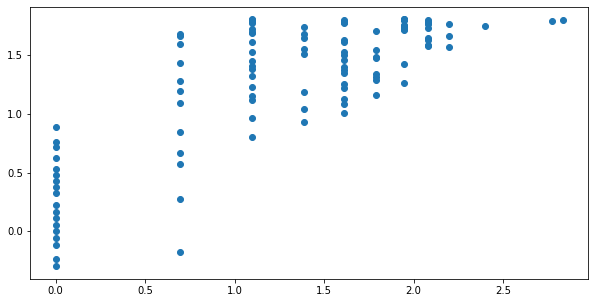

In [ ]:
M1MuerteLogTrain['casos_muerte_fitfinal']=M1MuerteLogTrain['casos_muerte_fit']+M1MuerteLogTrain['Errores_fit']
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


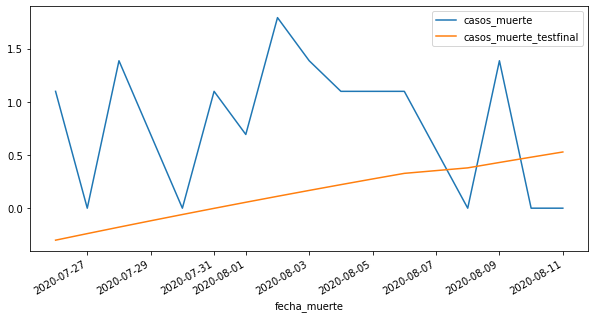

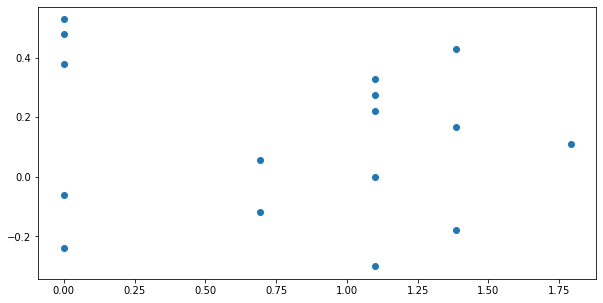

In [ ]:
M1MuerteLogTest['Errores_test']=arima.predict(n_periods=(len(M1MuerteLogTest)))
M1MuerteLogTest['casos_muerte_testfinal']=M1MuerteLogTest['casos_muerte_test']+M1MuerteLogTest['Errores_test']

plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_testfinal'])
plt.show() 

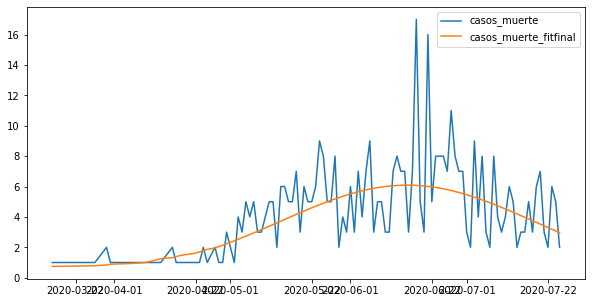

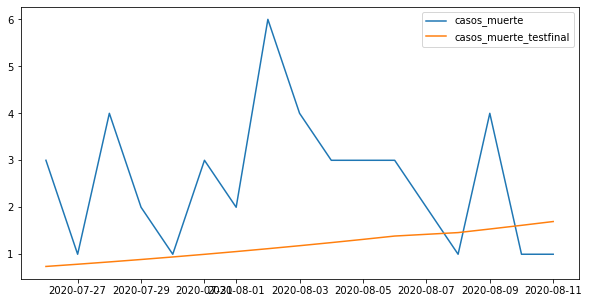

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fitfinal'])
plt.legend(['casos_muerte','casos_muerte_fitfinal'])
plt.show()

FM1Muerte=np.exp(M1MuerteLogTest)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_testfinal'])
plt.legend(['casos_muerte','casos_muerte_testfinal'])
plt.show()

#x_fore=M1MuerteLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Recuperado ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

In [ ]:
tabla_recuperado

,fecha_recuperado,casos_recuperado
0,2020-03-17,1
1,2020-03-25,3
2,2020-03-27,2
3,2020-03-28,1
4,2020-03-29,2
...,...,...
150,2020-08-28,96
151,2020-08-29,76
152,2020-08-30,127
153,2020-08-31,164


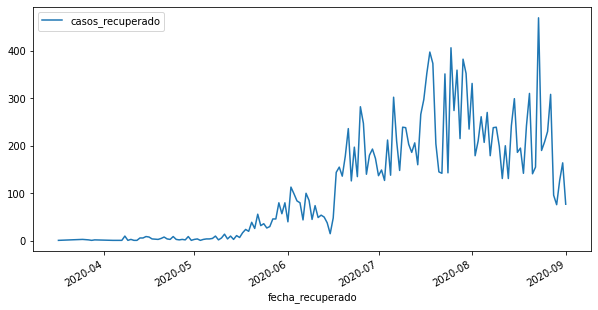

In [ ]:
tabla_recuperado.plot(x='fecha_recuperado',y='casos_recuperado',figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


mean1=23.576923, mean2=216.909091
variance1=832.705621, variance2=6780.939787


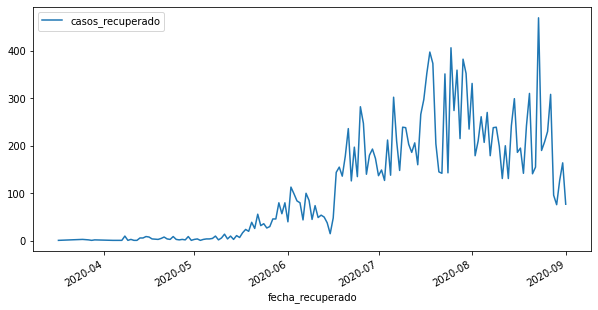

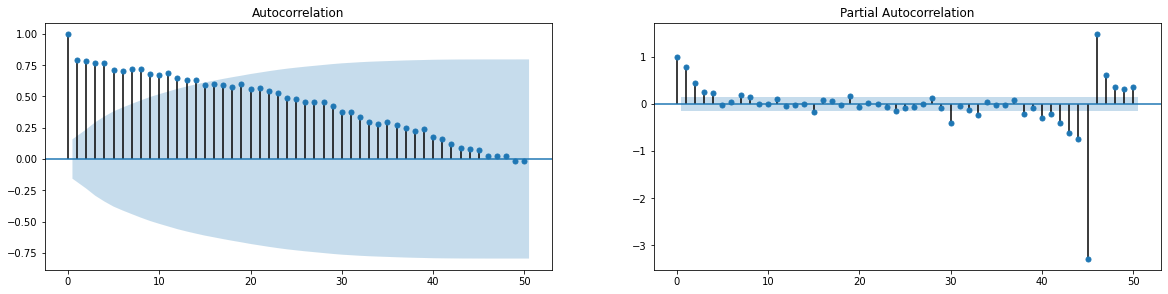

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M1Recuperado.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Recuperado.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Recuperado, lags=50, ax=ax2)

X=M1Recuperado.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2.228816, mean2=5.309308
variance1=2.211080, variance2=0.142193


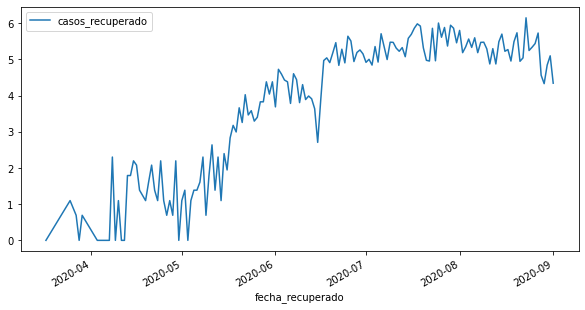

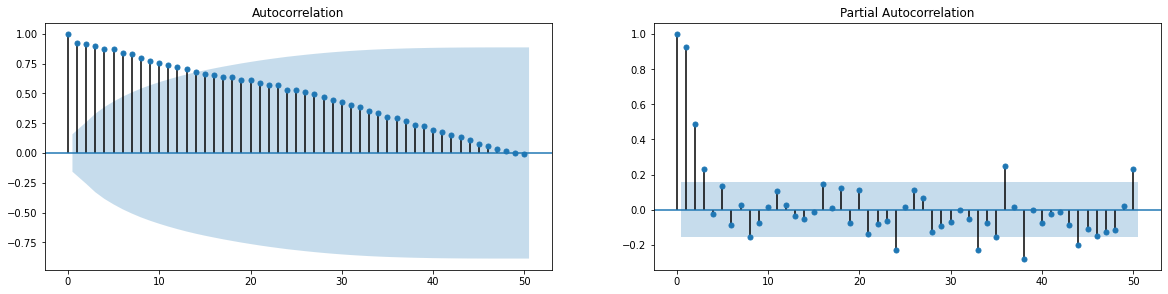

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1RecuperadoLog=np.log(M1Recuperado)
plt.rcParams["figure.figsize"] = (10,5)
M1RecuperadoLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLog, lags=50, ax=ax2)

X=M1RecuperadoLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

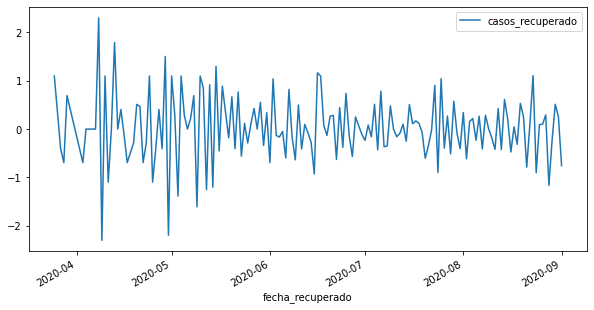

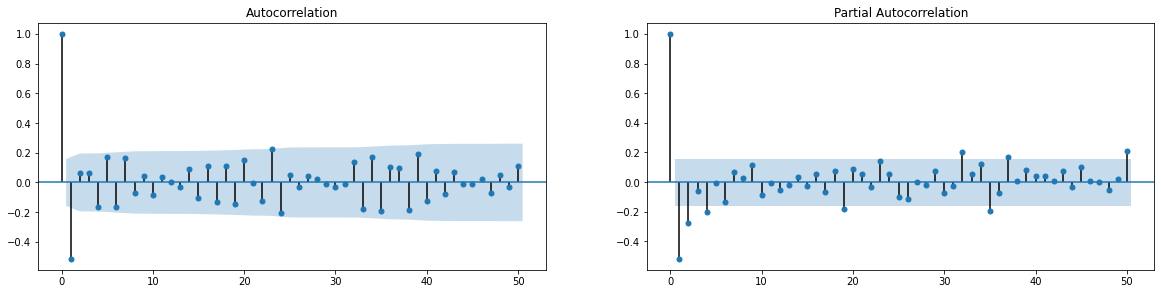

In [ ]:
# Primera diferencia para volver estacional
M1RecuperadoLogDif=M1RecuperadoLog.diff()
M1RecuperadoLogDif=M1RecuperadoLogDif[1:]
M1RecuperadoLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(155, 1)
(124, 1)
(18, 1)
(13, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  124
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -108.408
Date:                Wed, 02 Sep 2020   AIC                            222.817
Time:                        18:51:13   BIC                            231.253
Sample:                             0   HQIC                           226.243
                                - 124                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0444      0.017      2.559      0.010       0.010       0.078
ma.L1         -0.6811      0.066    -10.345      0.000      -0.810      -0.552
sigma2         0.3395      0.040      8.499      0.000       0.261       0.418
===================================================================================
Ljung-Box (Q):                       50.81   Jarque-Bera (JB):                 2.53
Prob(Q):                              0.12   Prob(JB):                         0.28
Heteroskedasticity (H):               0.21   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


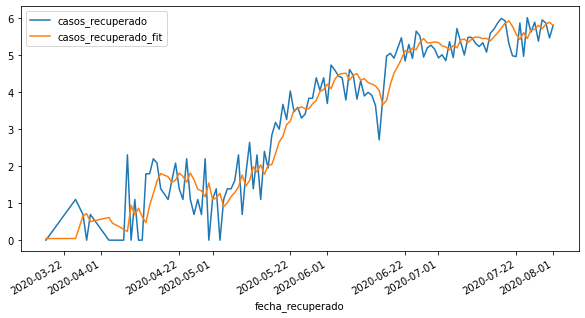

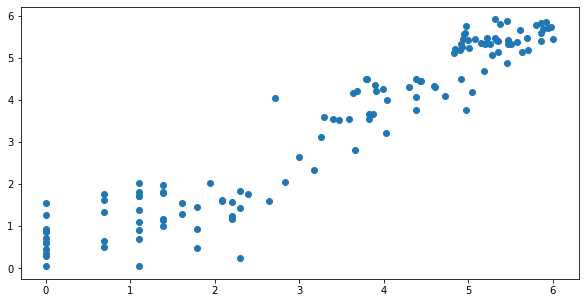

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


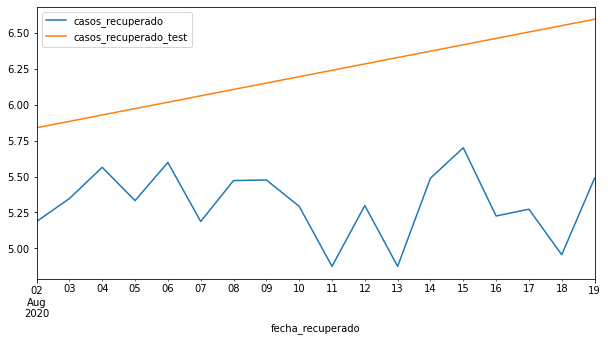

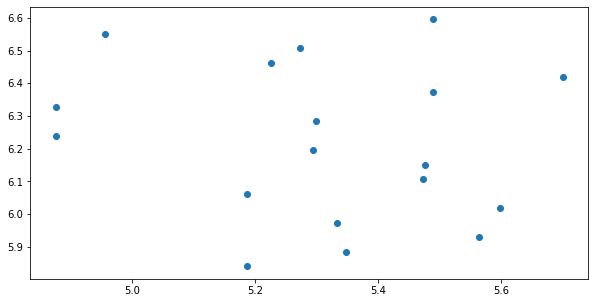

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()



M1RecuperadoLogTest['casos_recuperado_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest))) 
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

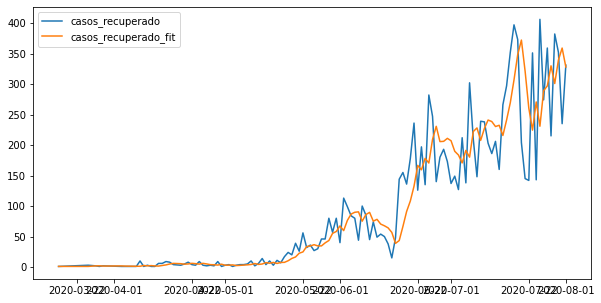

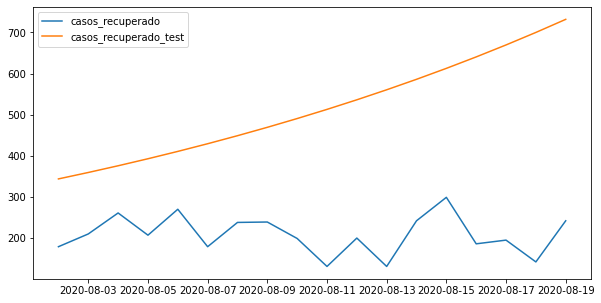

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fit'])
plt.legend(['casos_recuperado','casos_recuperado_fit'])
plt.show()

FM1RecuperadoTest=np.exp(M1RecuperadoLogTest)
plt.plot(FM1RecuperadoTest['casos_recuperado'])
plt.plot(FM1RecuperadoTest['casos_recuperado_test'])
plt.legend(['casos_recuperado','casos_recuperado_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Recuperado['casos_recuperado'],FM1Recuperado['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1RecuperadoTest['casos_recuperado'],FM1RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 2628.063690
MSE in test: 111340.880041


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(153, 1)
(122, 1)
(18, 1)
(13, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


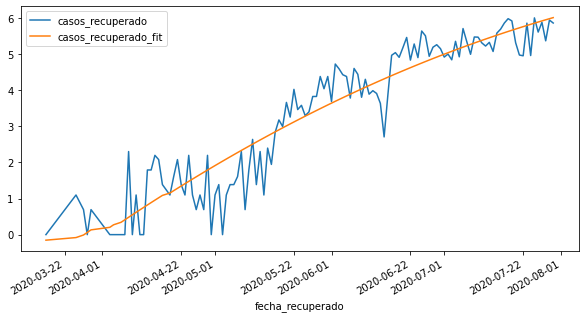

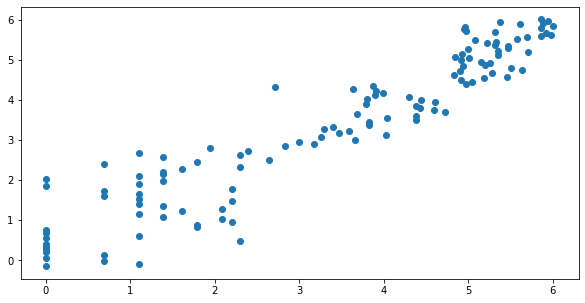

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


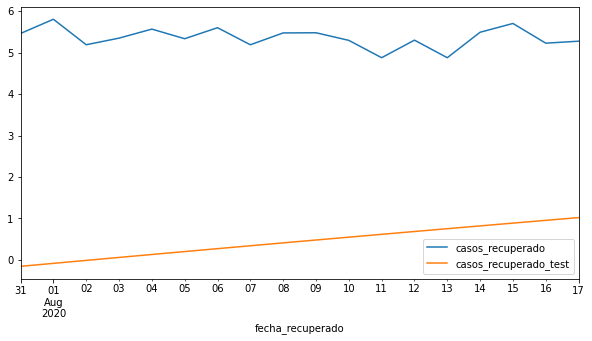

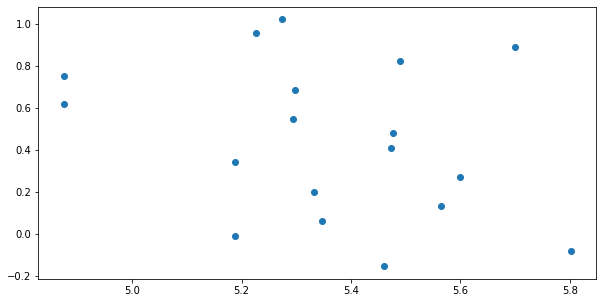

Mean squared error: 0.44
Variance score: 0.88


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1RecuperadoLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1RecuperadoLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1RecuperadoLogTrain['casos_recuperado'].values.reshape(-1,1))
M1RecuperadoLogTrain['casos_recuperado_fit']=model.predict(x_trainpoly)

plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()

M1RecuperadoLogTest['casos_recuperado_test']=model.predict(x_testpoly)
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])))

print('Variance score: %.2f' % r2_score(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit']))

#
#Mean squared error: 0.24
#Variance score: 0.94

# LinnearRegression() 

In [ ]:
M1RecuperadoLogTrain['Errores']=M1RecuperadoLogTrain['casos_recuperado']-M1RecuperadoLogTrain['casos_recuperado_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/loc

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -101.265
Date:                Tue, 01 Sep 2020   AIC                            212.529
Time:                        03:15:10   BIC                            226.549
Sample:                             0   HQIC                           218.224
                                - 122                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5528      0.168     -3.289      0.001      -0.882      -0.223
ar.L2          0.4992      0.104      4.791      0.000       0.295       0.703
ar.L3          0.4098      0.066      6.222      0.000       0.281       0.539
ma.L1          0.8115      0.178      4.561      0.000       0.463       1.160
sigma2         0.3062      0.031      9.778      0.000       0.245       0.368
===================================================================================
Ljung-Box (Q):                       37.67   Jarque-Bera (JB):                 7.41
Prob(Q):                              0.58   Prob(JB):                         0.02
Heteroskedasticity (H):               0.24   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


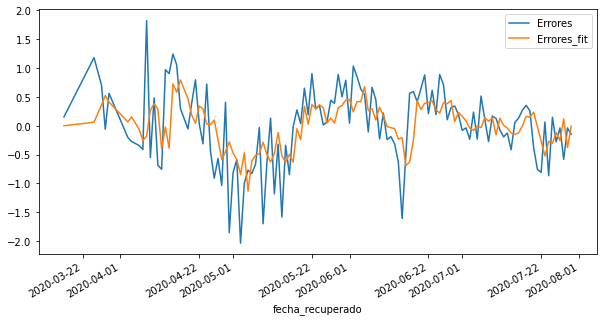

In [ ]:
M1RecuperadoLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


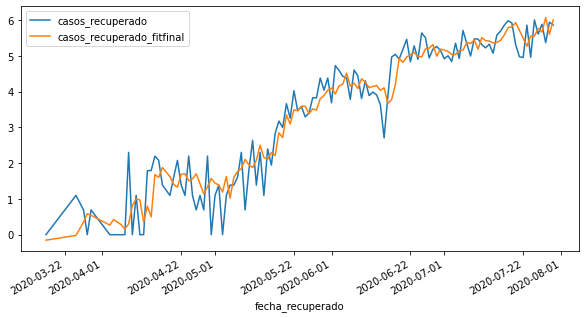

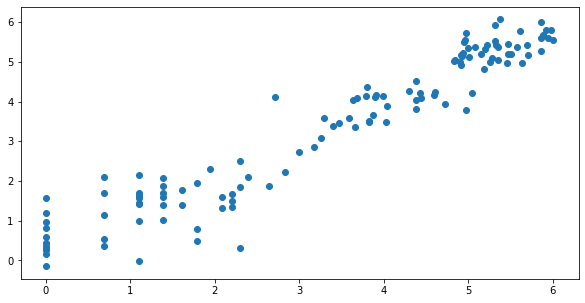

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fitfinal']=M1RecuperadoLogTrain['casos_recuperado_fit']+M1RecuperadoLogTrain['Errores_fit']
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


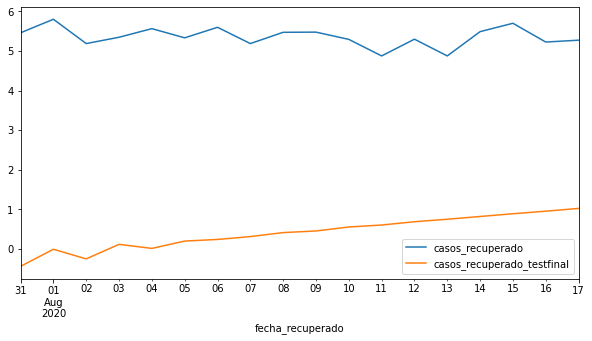

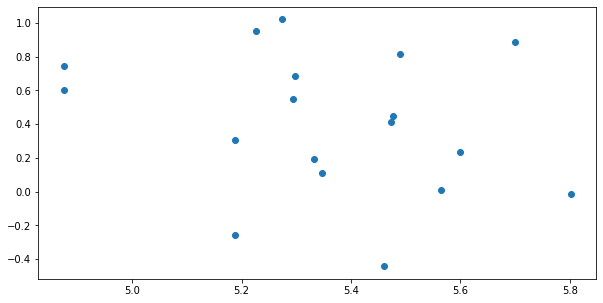

In [ ]:
M1RecuperadoLogTest['Errores_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest)))
M1RecuperadoLogTest['casos_recuperado_testfinal']=M1RecuperadoLogTest['casos_recuperado_test']+M1RecuperadoLogTest['Errores_test']

plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_testfinal'])
plt.show() 

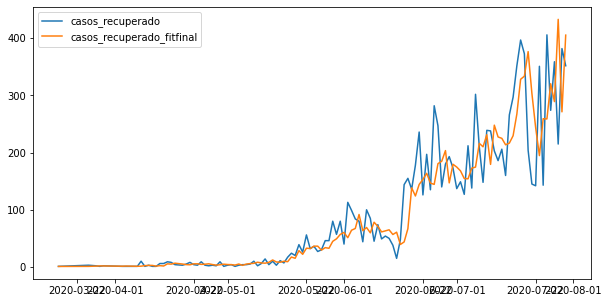

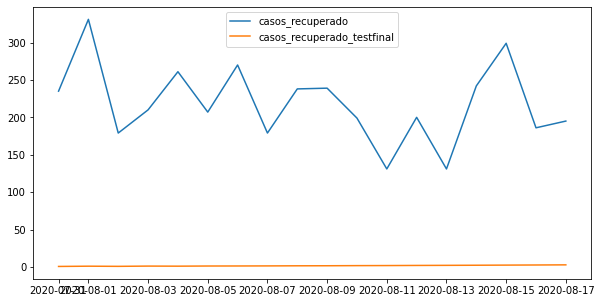

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fitfinal'])
plt.legend(['casos_recuperado','casos_recuperado_fitfinal'])
plt.show()

FM1Recuperado=np.exp(M1RecuperadoLogTest)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_testfinal'])
plt.legend(['casos_recuperado','casos_recuperado_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 2: Nuevos RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


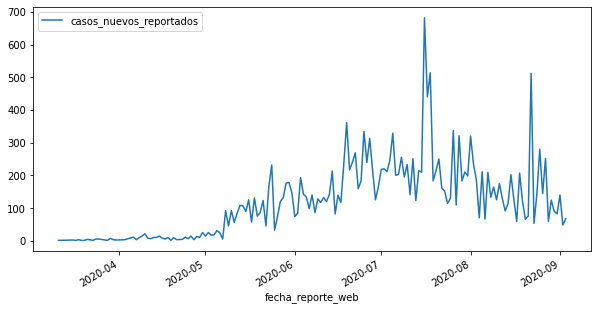

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M2Nuevos.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2NuevosTrain=M2Nuevos[:int(len(M2Nuevos)*p_train)]
M2NuevosTest=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]
M2NuevosForecast=M2Nuevos[int(len(M2Nuevos)*(p_train+p_test)):]
print(M2Nuevos.shape)
print(M2NuevosTrain.shape)
print(M2NuevosTest.shape)
print(M2NuevosForecast.shape)

(166, 1)
(132, 1)
(20, 1)
(14, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2NuevosTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2NuevosTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(125, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0485
Epoch 2/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0257
Epoch 3/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0239
Epoch 4/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0227
Epoch 5/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0188
Epoch 6/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0168
Epoch 7/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0159
Epoch 8/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0159
Epoch 9/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0165
Epoch 10/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0146
Epoch 11/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0148
Epoch 12/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0144
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModCartagenaNuevos.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Nuevos[:int(len(M2Nuevos)*p_train)]
dataset_test=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2NuevosTrain['casos_nuevos_reportados_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2NuevosTest['casos_nuevos_reportados_test']=predicted

(20, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


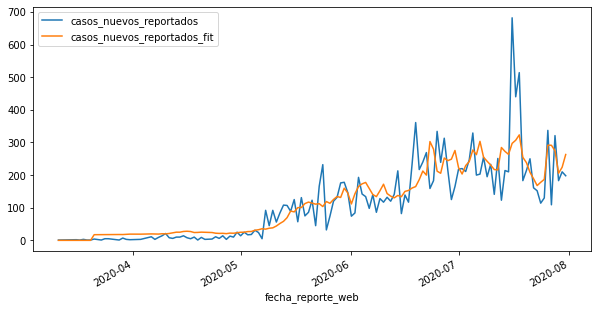

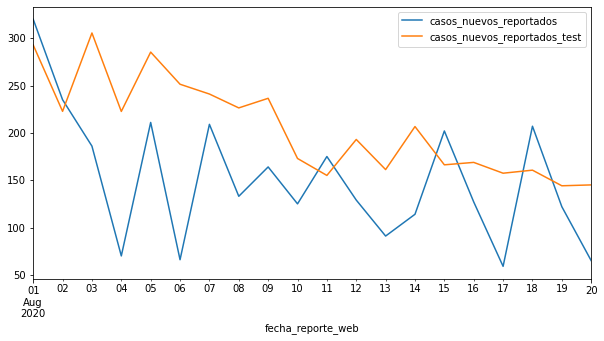

In [ ]:
plot=M2NuevosTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plot=M2NuevosTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2NuevosTrain['casos_nuevos_reportados'],M2NuevosTrain['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2NuevosTest['casos_nuevos_reportados'],M2NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 4075.315214
MSE in test: 6770.064619


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


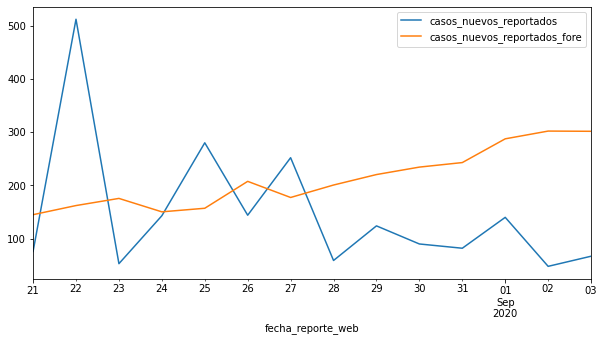

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2NuevosForecast['casos_nuevos_reportados_fore']=fore

plot=M2NuevosForecast[['casos_nuevos_reportados', 'casos_nuevos_reportados_fore']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


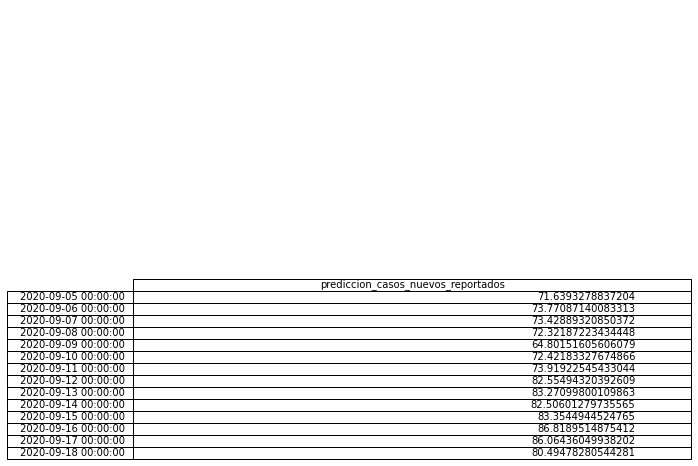

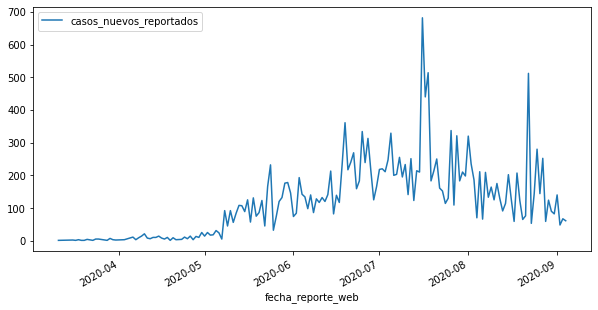

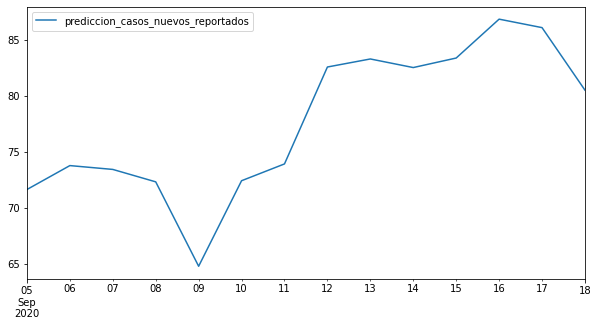

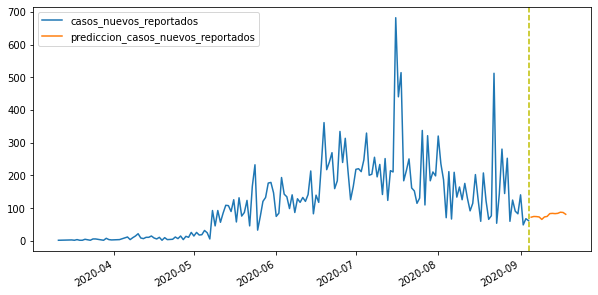

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Nuevos[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

from keras.models import load_model
model = load_model('ModCartagenaNuevos.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

CartagenaNuevos=sc.inverse_transform(b)

import datetime
index=[M2Nuevos.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
CartagenaNuevos=pd.DataFrame(data=CartagenaNuevos, index=index, columns=['prediccion_casos_nuevos_reportados'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, CartagenaNuevos) 
plt.savefig('./images/39.png')

M2Nuevos.plot().figure.savefig('./images/37.png')

CartagenaNuevos.plot().figure.savefig('./images/38.png')

total=pd.concat((M2Nuevos,CartagenaNuevos),axis = 0)
total.plot()
plt.axvline(x=M2Nuevos.index[-1],color='y',linestyle='--')
plt.savefig('./images/40.png')

CartagenaNuevos.to_excel('CartagenaNuevos.xlsx')

# Metodología 2: Muerte RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

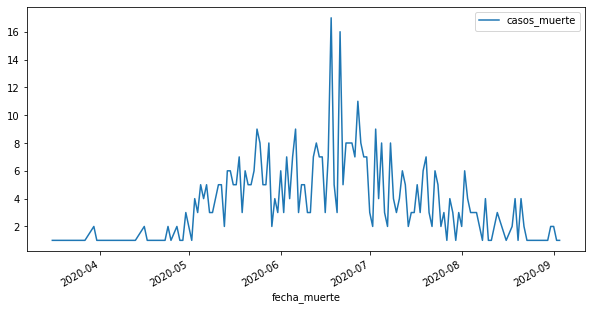

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M2Muerte.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2MuerteTrain=M2Muerte[:int(len(M2Muerte)*p_train)]
M2MuerteTest=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]
M2MuerteForecast=M2Muerte[int(len(M2Muerte)*(p_train+p_test)):]
print(M2Muerte.shape)
print(M2MuerteTrain.shape)
print(M2MuerteTest.shape)
print(M2MuerteForecast.shape)

(140, 1)
(112, 1)
(16, 1)
(12, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2MuerteTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2MuerteTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(105, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0706
Epoch 2/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0353
Epoch 3/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0307
Epoch 4/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0273
Epoch 5/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0278
Epoch 6/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0259
Epoch 7/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0248
Epoch 8/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0239
Epoch 9/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0236
Epoch 10/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0233
Epoch 11/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0238
Epoch 12/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0238
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModCartagenaMuerte.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Muerte[:int(len(M2Muerte)*p_train)]
dataset_test=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2MuerteTrain['casos_muerte_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2MuerteTest['casos_muerte_test']=predicted

(16, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


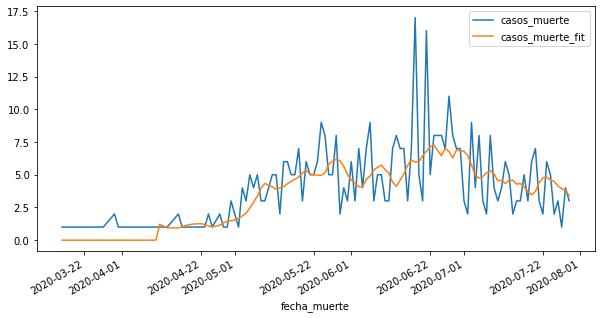

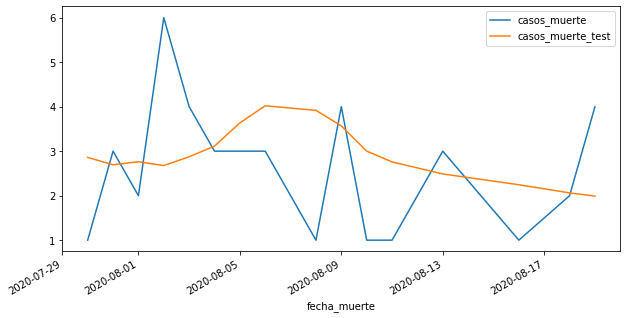

In [ ]:
plot=M2MuerteTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plot=M2MuerteTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2MuerteTrain['casos_muerte'],M2MuerteTrain['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2MuerteTest['casos_muerte'],M2MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 5.276720
MSE in test: 2.471720


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


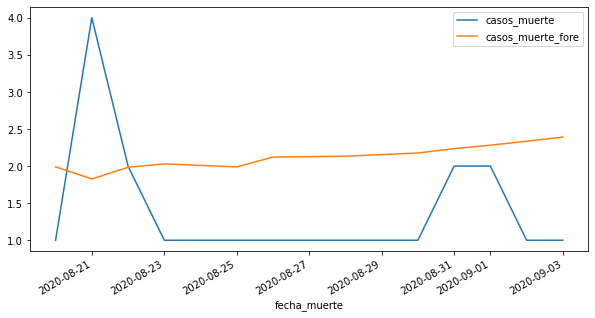

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,13):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2MuerteForecast['casos_muerte_fore']=fore

plot=M2MuerteForecast[['casos_muerte', 'casos_muerte_fore']].plot(figsize=(10, 5))

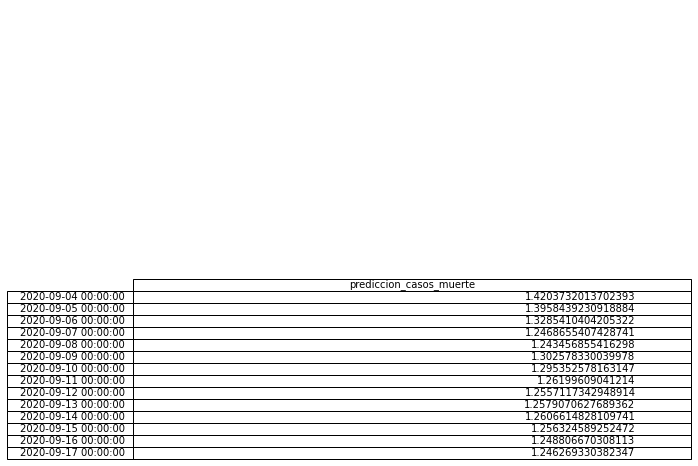

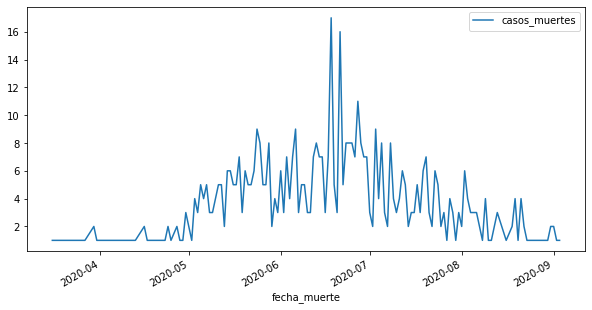

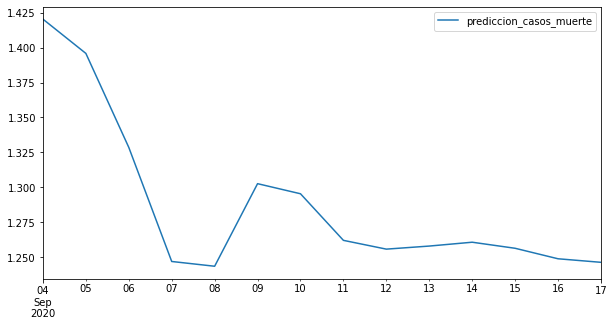

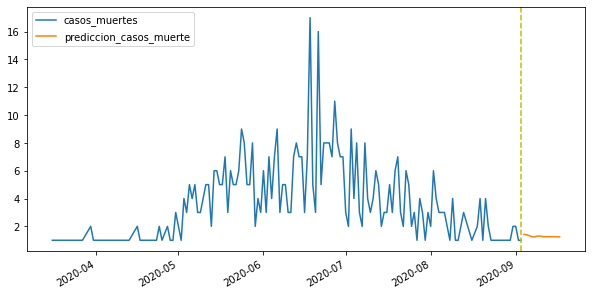

In [ ]:
# tabla con ciudades filtradas para modelar casos muerte
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muertes'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Muerte[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModCartagenaMuerte.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

CartagenaMuerte=sc.inverse_transform(b)

import datetime
index=[M2Muerte.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
CartagenaMuerte=pd.DataFrame(data=CartagenaMuerte, index=index, columns=['prediccion_casos_muerte'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, CartagenaMuerte) 
plt.savefig('images/43.png')

M2Muerte.plot().figure.savefig('images/41.png')

CartagenaMuerte.plot().figure.savefig('images/42.png')

total=pd.concat((M2Muerte,CartagenaMuerte),axis = 0)
total.plot()
plt.axvline(x=M2Muerte.index[-1],color='y',linestyle='--')
plt.savefig('images/44.png')

CartagenaMuerte.to_excel('CartagenaMuerte.xlsx')

# Metodología 2: Recuperados RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

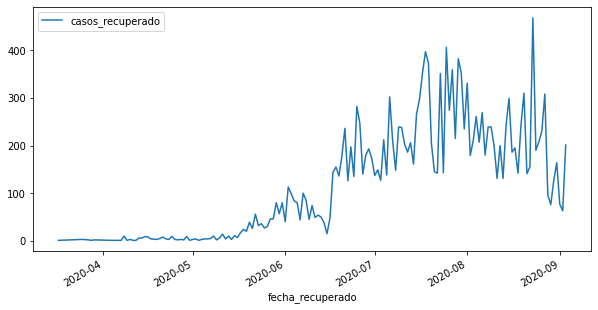

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M2Recuperado.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2RecuperadoTrain=M2Recuperado[:int(len(M2Recuperado)*p_train)]
M2RecuperadoTest=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]
M2RecuperadoForecast=M2Recuperado[int(len(M2Recuperado)*(p_train+p_test)):]
print(M2Recuperado.shape)
print(M2RecuperadoTrain.shape)
print(M2RecuperadoTest.shape)
print(M2RecuperadoForecast.shape)

(157, 1)
(125, 1)
(19, 1)
(13, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2RecuperadoTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2RecuperadoTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(118, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 22ms/step - loss: 0.1286
Epoch 2/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0620
Epoch 3/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0597
Epoch 4/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0371
Epoch 5/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0335
Epoch 6/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0255
Epoch 7/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0238
Epoch 8/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0230
Epoch 9/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0215
Epoch 10/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0208
Epoch 11/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0209
Epoch 12/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0207
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModCartagenaRecuperado.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Recuperado[:int(len(M2Recuperado)*p_train)]
dataset_test=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2RecuperadoTrain['casos_recuperado_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2RecuperadoTest['casos_recuperado_test']=predicted

(19, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


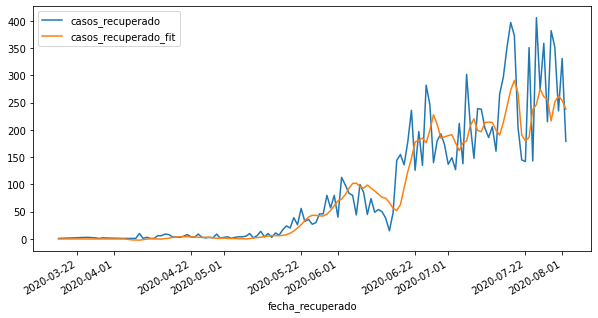

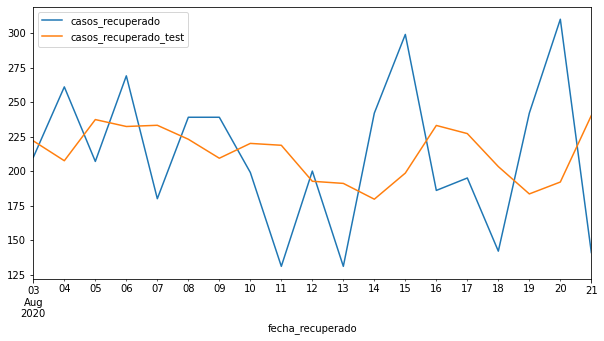

In [ ]:
plot=M2RecuperadoTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plot=M2RecuperadoTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2RecuperadoTrain['casos_recuperado'],M2RecuperadoTrain['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2RecuperadoTest['casos_recuperado'],M2RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 2325.109508
MSE in test: 3641.740159


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


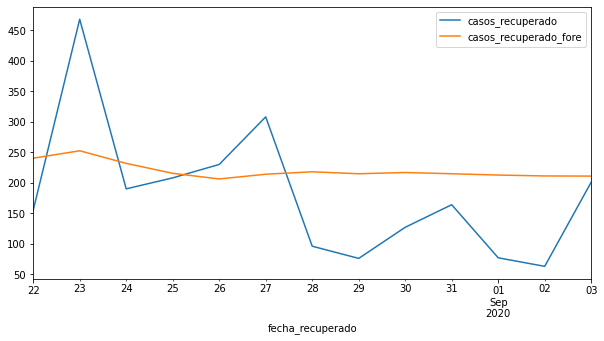

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,14):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2RecuperadoForecast['casos_recuperado_fore']=fore

plot=M2RecuperadoForecast[['casos_recuperado', 'casos_recuperado_fore']].plot(figsize=(10, 5))

Terminé recuperados


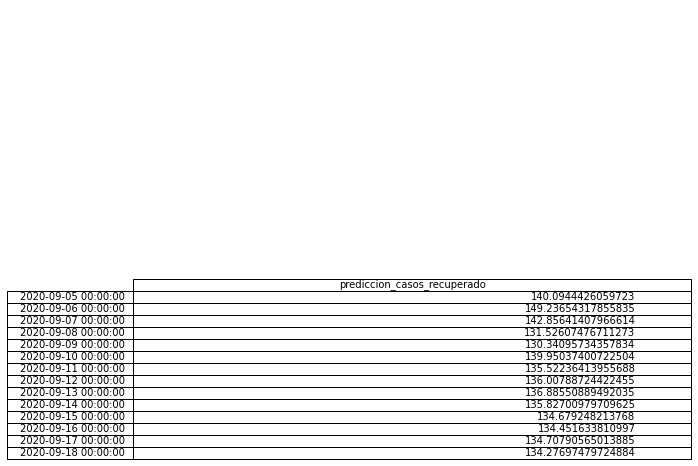

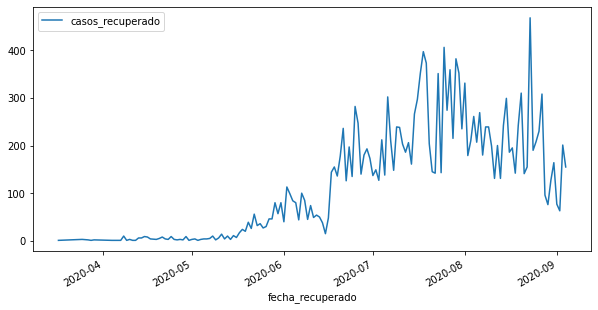

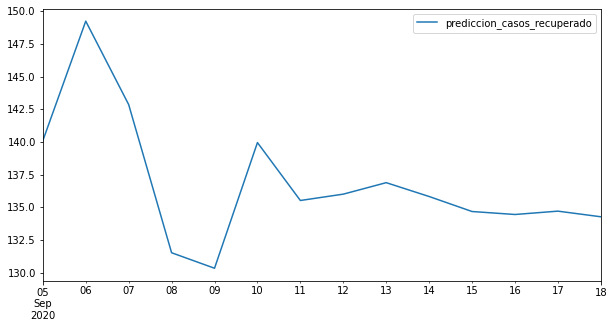

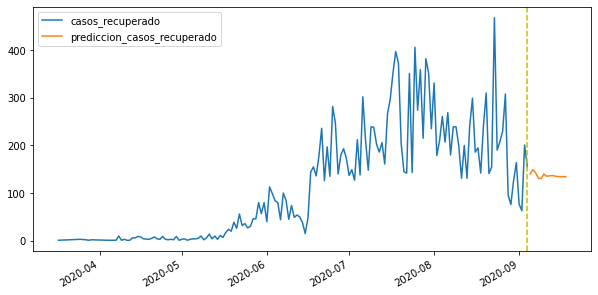

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperado
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Recuperado[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModCartagenaRecuperado.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

CartagenaRecuperado=sc.inverse_transform(b)

import datetime
index=[M2Recuperado.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
CartagenaRecuperado=pd.DataFrame(data=CartagenaRecuperado, index=index, columns=['prediccion_casos_recuperado'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, CartagenaRecuperado) 
plt.savefig('images/47.png')

M2Recuperado.plot().figure.savefig('images/45.png')

CartagenaRecuperado.plot().figure.savefig('images/46.png')

total=pd.concat((M2Recuperado,CartagenaRecuperado),axis = 0)
total.plot()
plt.axvline(x=M2Recuperado.index[-1],color='y',linestyle='--')
plt.savefig('images/48.png')

print("Terminé recuperados")


CartagenaRecuperado.to_excel('CartagenaRecuperado.xlsx')